# Classification of Wines

In this notebook we will apply different classification algorithms to a [dataset of wines](https://archive.ics.uci.edu/ml/datasets/wine) which contains 178 wines from three different cultivars along with their chemical composition which is specified in terms of 13 constituents.

We will train six different classification alorighms implemented in `scikit-learn` (perceptron, logistic regression, support vector machines, decision trees, random forests, and k-nearest neighbors) on the data, with the three cultivars being the class labels. In order to be able to visualize the training and test set as well as the models, we will reduce the dimensionality of the features from 13 to 2 using principal coponent analysis (PCA).

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

First we load the dataset which is available on the website of UC Irvine and add the appropriate column labels.

In [3]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
          'ml/machine-learning-databases/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# Train-Test Splitting and Standardization

First, we split the 178 samples into a training and a test set, with the training set making up 70% of the samples.

In [4]:
# Separate features (X) and class labels (y)
X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
# Split dataset into training and test set
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.3, random_state=0)

Next, we standardize the features to make them suitable for some of the algorithms such as logistic regression. The standardized features are stored in `X_train_std` and `X_test_std`.

In [5]:
# Standardize features
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

We will now take a quick look at the data to make sure there are no features with strong outliers. It doesn't look that way.

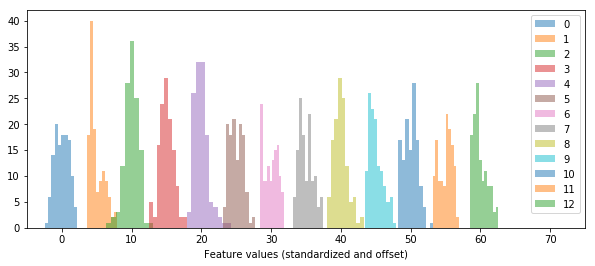

In [6]:
plt.figure(figsize=(10,4))
for i in range(13):
    plt.hist(X_train_std[:,i]+5*i, alpha=0.5, label=str(i))
plt.xlabel('Feature values (standardized and offset)')
plt.xlim(-5,75)
plt.legend()
plt.show()

# Dimensionality Reduction with Principal Component Analysis

We want to be able to visualize how well the different models reproduce the training data and how well they predict the test data. To be able to do so, we use principal component analysis to reduce the dimensionality of the features from 13 to 2. The two principal components are stored in `X_train_pca` and `X_test_pca`. The two stronges principal components still account for 56% of the information.

In [7]:
# Principal Component Analysis
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
pca.explained_variance_ratio_

array([ 0.37329648,  0.18818926])

Having reduced the dimensionality of the features, we can plot the three different classes of wine in a two-dimensional plot where the color represents the class label (the following plot shows the training set).

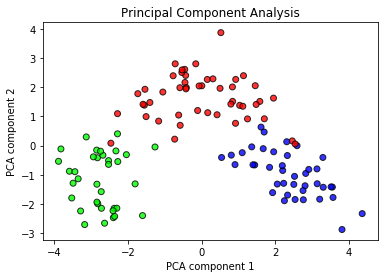

In [8]:
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], 
            c=y_train, cmap='brg', edgecolor='black', alpha=0.8)
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('Principal Component Analysis')
plt.show()

We can see that the three classes of wine well separated even in this two-dimensional space. We can now proceed to training the classification models.

After employing the different classification algorithms, we will want to compare their respective accuracy scores on the test set. We will save the different scores in a dictionary:

In [9]:
cv_scores = {}

# Functions to Plot Trained Models and Validation Curves

When training the classifiers, we will want to plot the respective models in the two-dimensional feature space. The following function visualizes a given, trained classification model (passed in `est`) by plotting the predicted class label as a color-coded area and overlaying it with the color-coded training and test set, respectively, in two plots. It also prints the cross-validation score of the model on the training set.

In [10]:
def classifier_plot(name, est):
    cmap = 'brg' # used colormap
    X_dat = X_train_pca      # two-dimensional training features
    X_dat_test = X_test_pca  # two-dimensional test features
    y_dat = y_train          # taining class labels
    y_dat_test = y_test      # test class labels
    
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    
    # Determine minima and maxima of entire dataset 
    # (training and test sets)
    x_min = np.concatenate((X_dat[:,0], X_dat_test[:,0])).min() - 0.5
    x_max = np.concatenate((X_dat[:,0], X_dat_test[:,0])).max() + 0.5
    y_min = np.concatenate((X_dat[:,1], X_dat_test[:,1])).min() - 0.5
    y_max = np.concatenate((X_dat[:,1], X_dat_test[:,1])).max() + 0.5
        
    # Plot estimator prediction as contour plot
    grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, 0.01), 
                                 np.arange(y_min, y_max, 0.01))
    grid_class = est.predict(np.array([grid_x.ravel(), 
                                       grid_y.ravel()]).T)
    grid_class = grid_class.reshape(grid_x.shape)
    ax[0].contourf(grid_x, grid_y, grid_class, alpha=0.2, cmap=cmap)
    ax[1].contourf(grid_x, grid_y, grid_class, alpha=0.2, cmap=cmap)

    # Plot training data (left plot)
    ax[0].scatter(X_dat[:,0], X_dat[:,1], 
                  c=y_dat, cmap=cmap, edgecolor='black', alpha=0.8)
    ax[0].set_xlabel('PCA component 1')
    ax[0].set_ylabel('PCA component 2')
    ax[0].set_title(name+' (Training Set)')

    # Plot test data (right plot)
    ax[1].scatter(X_dat_test[:,0], X_dat_test[:,1], c=y_dat_test, cmap=cmap, edgecolor='black', alpha=0.8)
    ax[1].set_xlabel('PCA component 1')
    ax[1].set_ylabel('PCA component 2')
    ax[1].set_title(name+' (Test Set)')
    plt.show()
    
    # Print cross validation score
    cv = cross_val_score(estimator=est, X=X_dat, y=y_dat, cv=10)
    print('Cross-validation score: %.3f +/- %.3f' % (cv.mean(), cv.std()) )

The following function plots a validation curve, i.e. the scores on the training and test sets as a function of a given parameter.

In [11]:
def validation_curve_plot(est, param_name, param_range, log_scale=False):
    train_scores, test_scores = validation_curve(
                    estimator=est, 
                    X=X_train_pca, 
                    y=y_train, 
                    param_name=param_name, 
                    param_range=param_range,
                    cv=10)

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.plot(param_range, train_mean, label='training scores')
    plt.plot(param_range, test_mean, label='validation scores')

    if log_scale==True:
        plt.xscale('log')
    plt.grid()
    plt.xlabel('Parameter: '+param_name)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Perceptron

The first classifier that we will investigate is the perceptron algorithm, implemented in `scikit-learn` as `Perceptron`. We will train it on the training set with reduced dimensionality:

In [12]:
ppn = Perceptron(max_iter=101, eta0=0.1)
ppn.fit(X_train_pca, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      max_iter=101, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)

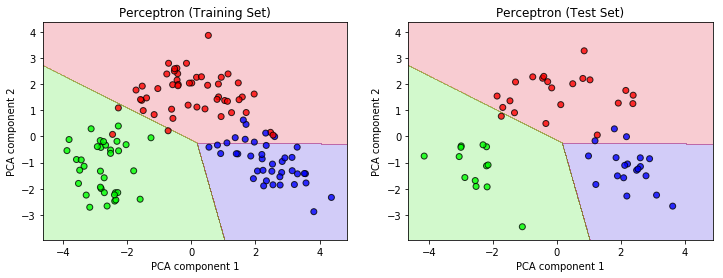

Cross-validation score: 0.961 +/- 0.052


In [13]:
classifier_plot('Perceptron', ppn)

Using the above function `classifier_plot`, we can visualize how the perceptron algorithm performs on our dataset. Even after 100 iterations, there are still several samples in the training set that the model doesn't classify correctly. This is because the classes cannot be seprated perfectly by a linear model and the perceptron cannot converge under these circumstances. This becomes clear from a validation curve as a function of iterations. The accuracy oscillates heavily as the model keeps changing in each iteration.

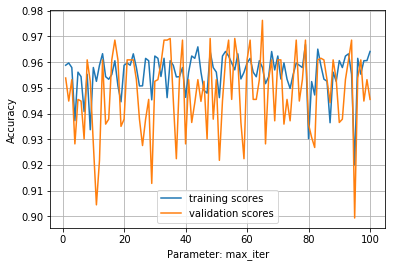

In [14]:
validation_curve_plot(ppn, 'max_iter', np.arange(1,101,1))

We can now proceed and predict the class labels of the unseen test set. With the model trained with 101 iterations, we obtain an accuracy of 93%.

In [15]:
y_pred = ppn.predict(X_test_pca)
cv_scores['ppn']=accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.92592592592592593

# Logistic Regression

The second classification algorithm we use is logistic regression, as implemented in `scikit-learn`'s `LogisticRegression`.

In [16]:
# Logistic Regression
lr = LogisticRegression(C=0.1, random_state=0, penalty='l1')
lr.fit(X_train_pca, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

To fine-tune this model, we use a grid search to optimize the regularization (L1 vs. L2) and the inverse regularization strength `C`. The best model uses L1-regularization and `C=0.1`.

In [17]:
param_grid = [{'C': np.logspace(-3,3,7),
               'penalty': ['l1','l2'] }]

gs = GridSearchCV(estimator=lr, param_grid=param_grid, 
                  scoring='accuracy', cv=10)
gs = gs.fit(X_train_pca, y_train)
gs.best_params_

{'C': 0.10000000000000001, 'penalty': 'l1'}

As we can see in the below plot, the logistic regression model has no problems classifying the data as far as this is possible given the intersecting datapoints.

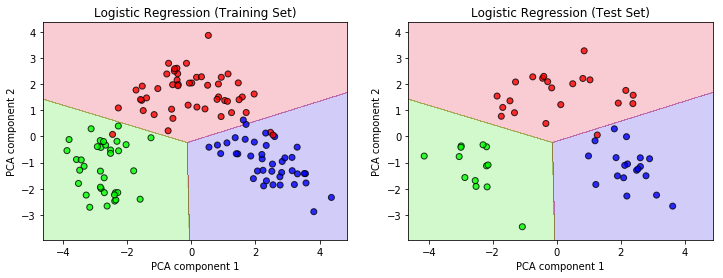

Cross-validation score: 0.969 +/- 0.039


In [18]:
classifier_plot('Logistic Regression', lr)

The accuracy of this model as measured on the test set is higher than that for the perceptron model.

In [19]:
y_pred = lr.predict(X_test_pca)
cv_scores['lr']=accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.98148148148148151

# Support Vector Machines

Next, we use a support vector machines classifier on the wine data. This allows us to use non-linear boundaries between the classification domains by using a kernel (e.g. radial basis functions, `rbf`).

We can play a little with the hyperparameter `gamma` which illustrates how choosing too large a `gamma` can lead to overfitting of the data. By choosing `gamma=100.0`, the model overfits drastically, confining the green and purple labels essentially to the samples in the training set. Not surprisingly, this gives a very bad cross-validation score of only 51%.

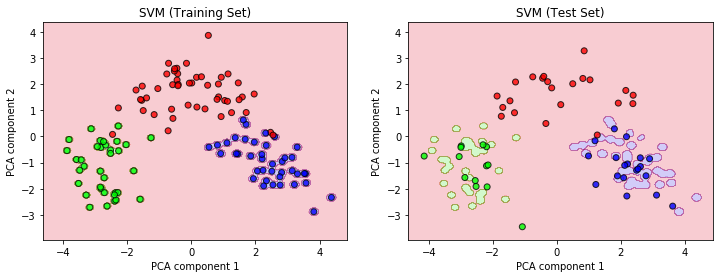

Cross-validation score: 0.512 +/- 0.102


In [20]:
# Reasonable choice of gamma=0.8
svm = SVC(kernel='rbf', C=1.0, gamma=100.0, random_state=0)
svm.fit(X_train_pca, y_train)
classifier_plot('SVM', svm)

Choosing `gamma=0.8`, we obtain a much more reasonable classification and a cross-validation score of 95%. The behavior of the model as a function of `gamma` can also be captured by the below validation curve: values between 0.003 and 1 give the best results.

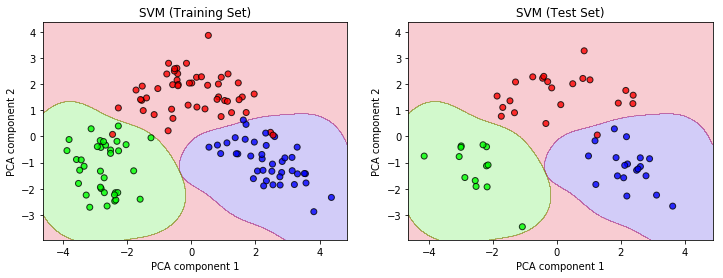

Cross-validation score: 0.953 +/- 0.051


In [21]:
svm = SVC(kernel='rbf', C=1.0, gamma=0.8, random_state=0)
svm.fit(X_train_pca, y_train)
classifier_plot('SVM', svm)

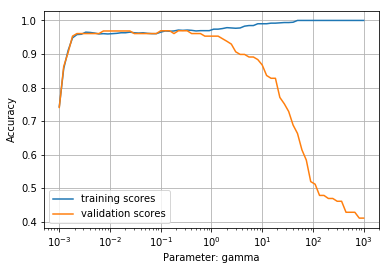

In [22]:
validation_curve_plot(svm, 'gamma', np.logspace(-3,3,70), log_scale=True)

In [23]:
y_pred = svm.predict(X_test_pca)
cv_scores['svm']=accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.98148148148148151

# Decision Tree

Now, we will use a decision tree classifier to classify our data. Here, the `max_depth` hyperparameter is critical because by setting this parameter to large values, the model quickly overfits the data. For example, setting `max_depth=10`, the mode unrealistically accomodates the red sampels lying in the green and purple regime.

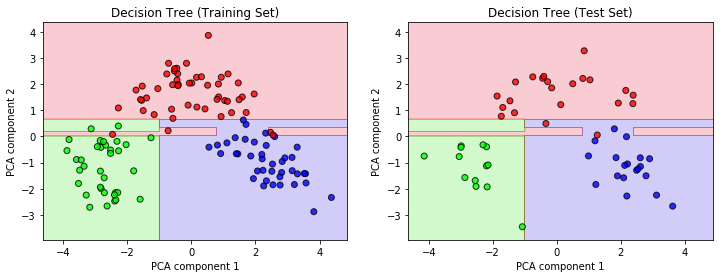

Cross-validation score: 0.929 +/- 0.073


In [24]:
tree = DecisionTreeClassifier(max_depth=10)
tree.fit(X_train_pca, y_train)
classifier_plot('Decision Tree', tree)

A validation curve shows that the ideal value for `max_depth` in this case is 3. When we re-train the model with this hyperparameter setting, the result is much more reasonable, even though it doesn't capture all the outliers of the training set.

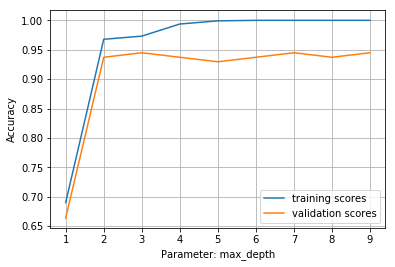

In [25]:
validation_curve_plot(tree, 'max_depth', np.arange(1,10))

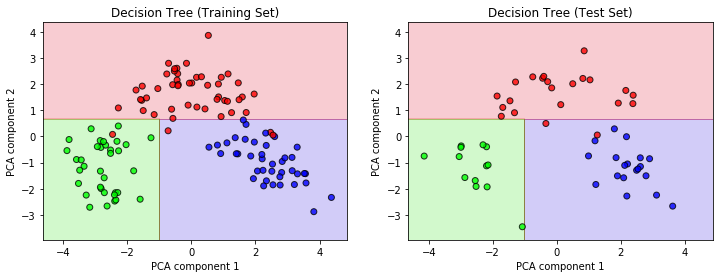

Cross-validation score: 0.945 +/- 0.050


In [26]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train_pca, y_train)
classifier_plot('Decision Tree', tree)

In [27]:
y_pred = tree.predict(X_test_pca)
cv_scores['tree']=accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.96296296296296291

# Random Forests

The random forest classifier combines an ensemble of decision trees and is therefore more robust than individual decision trees. The most important hyperparameter is `n_estimators`, the number of decision trees to be taken into account. While too high a number of trees leads to overfitting, the validation curve shows that by using even just a few trees, the training data are captured nicely.

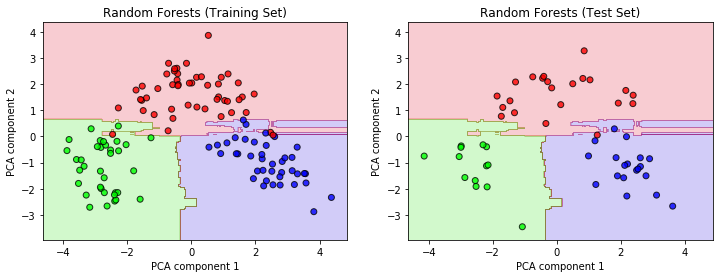

Cross-validation score: 0.937 +/- 0.047


In [28]:
forest = RandomForestClassifier(n_estimators=60)
forest.fit(X_train_pca, y_train)
classifier_plot('Random Forests', forest)

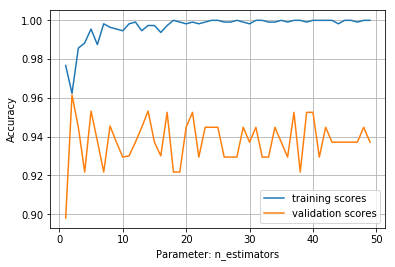

In [29]:
validation_curve_plot(forest, 'n_estimators', np.arange(1,50,1))

In [30]:
y_pred = forest.predict(X_test_pca)
cv_scores['forest']=accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.98148148148148151

# k-Nearest Neighbors

Finally, we use the k-nearest neighbors classifier which, unlike the other above examples, takes the training data into account explicitly when presented with new, unknown data. Specifically, it evaluates the class labels of a new sample's k nearest neighbors within the training set. In the `KNeighborsClassifier` function, k is represented by the hyperparameter `n_neighbors`.

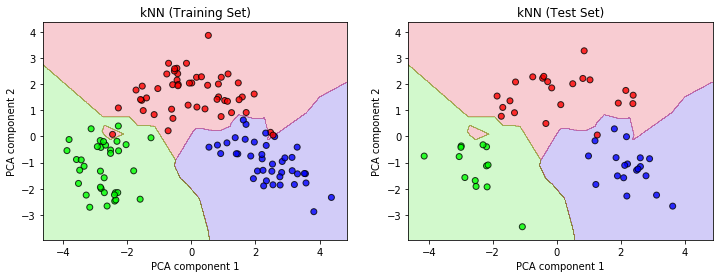

Cross-validation score: 0.929 +/- 0.088


In [31]:
knn = KNeighborsClassifier(n_neighbors=1, p=2)
knn.fit(X_train_pca, y_train)
classifier_plot('kNN', knn)

The above extreme choice of `n_neighbors=1` leads to overfitting. The following validation curve shows that 7 is the optimum for the hyperparameter `n_neighbors`.

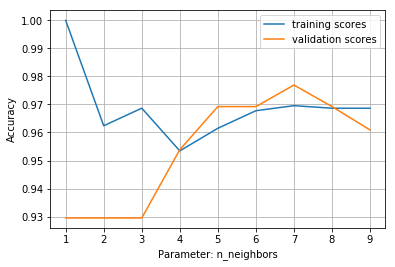

In [32]:
validation_curve_plot(knn, 'n_neighbors', np.arange(1,10,1))

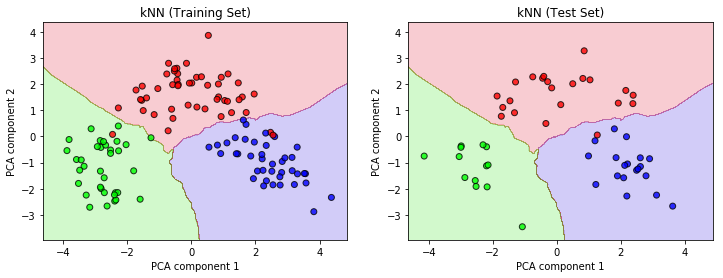

Cross-validation score: 0.977 +/- 0.035


In [33]:
knn = KNeighborsClassifier(n_neighbors=7, p=2)
knn.fit(X_train_pca, y_train)
classifier_plot('kNN', knn)

In [34]:
y_pred = knn.predict(X_test_pca)
cv_scores['knn']=accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.98148148148148151

# Comparison of Algorithms

In [35]:
cv_scores

{'forest': 0.98148148148148151,
 'knn': 0.98148148148148151,
 'lr': 0.98148148148148151,
 'ppn': 0.92592592592592593,
 'svm': 0.98148148148148151,
 'tree': 0.96296296296296291}

Comparing the six classification algorithms, we can summarize that four of them (logistic regression, support vector machines, random forests and k-nearest neighbors) achieved an accuracy of 98.1% on the test set. The limited number of samples and the fact that (using this specific training-test division) there is one red outlier of the red class prohibit the models from achieving a higher score. In fact, 98.1% accuracy means that out of 54 test samples, only one was misclassified.

By timing the learning of the four best algorithms, we see that the k-nearest neighbors classifiers can be trained the fastest, in 410 $\mu$s. This is thus the best-performing classifier for this dataset.

In [36]:
%timeit lr.fit(X_train_pca, y_train)

473 µs ± 134 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [37]:
%timeit svm.fit(X_train_pca, y_train)

650 µs ± 64.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [38]:
%timeit forest.fit(X_train_pca, y_train)

80.6 ms ± 7.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
%timeit knn.fit(X_train_pca, y_train)

410 µs ± 101 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
